In [1]:
import pandas as pd
import cv2
import numpy as np


dataset_path = 'fer2013/fer2013/fer2013.csv'
image_size=(48,48)

def load_fer2013():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).as_matrix()
        return faces, emotions

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [2]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

if __name__ == "__main__":
    input_shape = (64, 64, 1)
    num_classes = 7
    model = mini_XCEPTION(input_shape, num_classes)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 8)            72        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 62, 62, 8)            32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 62, 62, 8)            0         ['batch_normalization[0][0

 separable_conv2d_5 (Separa  (None, 15, 15, 64)           4672      ['activation_4[0][0]']        
 bleConv2D)                                                                                       
                                                                                                  
 batch_normalization_10 (Ba  (None, 15, 15, 64)           256       ['separable_conv2d_5[0][0]']  
 tchNormalization)                                                                                
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             2048      ['add_1[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)             0         ['batch_normalization_10[0][0]
 g2D)                                                               ']                            
          

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from models.cnn import mini_XCEPTION

# 데이터셋 경로 및 매개변수 설정
train_data_dir = 'archive/train'
validation_data_dir = 'archive/test'
batch_size = 32
num_classes = 7
input_shape = (48, 48, 1)

# 데이터 생성기 설정
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(48, 48),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(48, 48),
                                                              color_mode='grayscale',
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

# 모델 정의 (mini_XCEPTION 모델 사용)
model = mini_XCEPTION(input_shape, num_classes)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
epochs = 100
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

# 모델 저장
model.save('Emotion_Model_mini_XCEPTION.keras')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/100
897/897 [==============================] - 131s 144ms/step - loss: 1.7354 - accuracy: 0.3518 - val_loss: 1.5856 - val_accuracy: 0.4003
Epoch 2/100
897/897 [==============================] - 96s 107ms/step - loss: 1.4896 - accuracy: 0.4469 - val_loss: 1.5138 - val_accuracy: 0.4417
Epoch 3/100
897/897 [==============================] - 98s 109ms/step - loss: 1.3793 - accuracy: 0.4858 - val_loss: 1.4259 - val_accuracy: 0.4745
Epoch 4/100
897/897 [==============================] - 98s 109ms/step - loss: 1.3090 - accuracy: 0.5124 - val_loss: 1.3665 - val_accuracy: 0.4947
Epoch 5/100
897/897 [==============================] - 99s 110ms/step - loss: 1.2634 - accuracy: 0.5300 - val_loss: 1.2716 - val_accuracy: 0.5361
Epoch 6/100
897/897 [==============================] - 98s 110ms/step - loss: 1.2331 - accuracy: 0.5408 - val_loss: 1.4423 - val_accuracy: 0.4618
Epoch 7/100
897/897 [=================

897/897 [==============================] - 98s 110ms/step - loss: 0.8625 - accuracy: 0.6810 - val_loss: 1.0866 - val_accuracy: 0.6090
Epoch 57/100
897/897 [==============================] - 98s 109ms/step - loss: 0.8673 - accuracy: 0.6796 - val_loss: 1.1168 - val_accuracy: 0.6063
Epoch 58/100
897/897 [==============================] - 99s 110ms/step - loss: 0.8641 - accuracy: 0.6796 - val_loss: 1.2330 - val_accuracy: 0.5611
Epoch 59/100
897/897 [==============================] - 97s 109ms/step - loss: 0.8591 - accuracy: 0.6798 - val_loss: 1.0960 - val_accuracy: 0.6056
Epoch 60/100
897/897 [==============================] - 99s 110ms/step - loss: 0.8534 - accuracy: 0.6854 - val_loss: 1.0961 - val_accuracy: 0.6099
Epoch 61/100
897/897 [==============================] - 98s 109ms/step - loss: 0.8537 - accuracy: 0.6883 - val_loss: 1.1534 - val_accuracy: 0.6060
Epoch 62/100
897/897 [==============================] - 98s 109ms/step - loss: 0.8507 - accuracy: 0.6871 - val_loss: 1.1062 - val_a

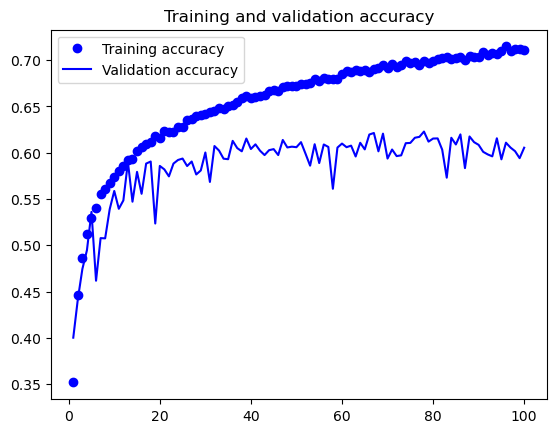

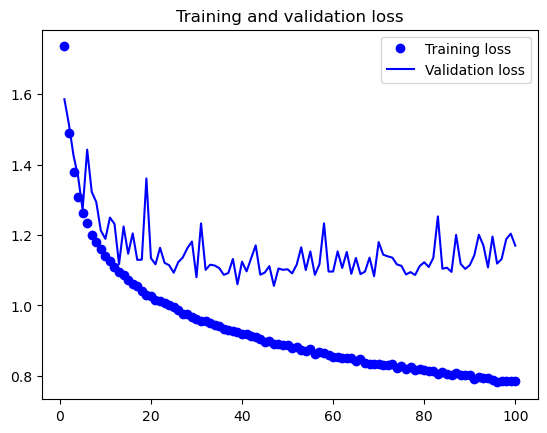

In [2]:
#그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

#정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [4]:
#최종_감정인식 확인
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import imutils

detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'Emotion_Model_mini_XCEPTION.keras'

face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry", "disgust", "scared", "happy", "sad", "surprised", "neutral"]

cv2.namedWindow('Emotion_recognition')
camera = cv2.VideoCapture(0)

while True:
    frame = camera.read()[1]
    frame = imutils.resize(frame, width=1080)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detection.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    frameClone = frame.copy()

    for (fX, fY, fW, fH) in faces:
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        preds = emotion_classifier.predict(roi)[0]
        emotion = EMOTIONS[np.argmax(preds)]

        text_x = fX + fW // 2
        text_y = fY - 10  # 위로 조금 올려서 텍스트가 얼굴 상단 중앙에 위치하도록 조정

        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (128, 128, 128), 5)
        cv2.putText(frameClone, emotion, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5)

    cv2.imshow('Emotion_recognition', frameClone)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


In [3]:
#모델 평가
test_loss, test_accuracy = model.evaluate(validation_generator, steps = validation_generator.samples // batch_size)

print("Test Loss : ", test_loss)
print("Test Accuracy : ", test_accuracy)

224/224 [==============================] - 4s 18ms/step - loss: 1.1706 - accuracy: 0.6052
Test Loss :  1.1706326007843018
Test Accuracy :  0.6051897406578064
